# [Numerical Analysis](https://www.math.sissa.it/course/phd-course-master-course/numerical-analysis-2021-2022) *end-of-course* project (a.y. 2021/2022)
by [Emanuele Ballarin](https://ballarin.cc) ([`emanuele@ballarin.cc`](mailto:emanuele@ballarin.cc))

Eventually-updated code available [on GitHub](https://github.com/emaballarin/numerical-analysis-2021-2022/tree/main/final_project) or [mirrored on SourceHut](https://git.sr.ht/~emaballarin/numerical-analysis-2021-2022/tree/main/item/final_project).

**NOTE:**  
The following *Jupyter Notebook* serves the purpose of *presentation* only.  
Numerics-related functions have been implemented in [functions.py](./functions.py) whereas [util.py](./util.py) contains generic utilities unrelated to Numerical Analysis (mostly: plotting).

In [1]:
# Jupyter/IPython magics
%matplotlib inline

In [2]:
# Module imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from util import symfrac_ticks

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [3]:
from functions import finite_difference

Call the function using:

In [4]:
omega = [0, np.pi]
f = lambda x: np.sin(x)
n = 100
bc = [0, 0]

In [5]:
a, b = finite_difference(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [6]:
from functions import lu_decomp, chol_decomp

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [7]:
from functions import l_solve, u_solve, lu_solve

Solve the derived linear system using the implemented functions and plot the computed solution:

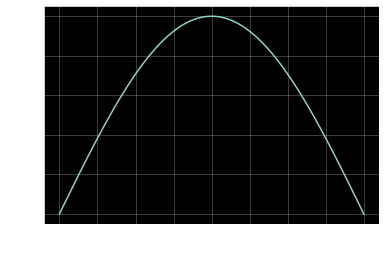

In [8]:
xs = np.linspace(0, np.pi, n)
_ = plt.plot(xs, lu_solve(a, b))
_ = plt.xticks(*symfrac_ticks(0, 9 / 8, 1 / 8, np.pi, "π"))
_ = plt.xlabel("x")
_ = plt.ylabel("u(x)")
_ = plt.grid(alpha=0.3, which="both")

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [9]:
omega_new = [0, 1]
f_new = lambda x: x * (1 - x)
u_analytical = np.vectorize(lambda x: x**4 / 12 - x**3 / 6 + x / 12)
bc_new = [0, 0]

In [10]:
min_n = 3
max_n = int(1e3)
step_n = 10
err_linf = []

for n_new in range(min_n, max_n, step_n):
    a_new, b_new = finite_difference(omega_new, f_new, n_new, bc_new)
    lu_sol = lu_solve(a_new, b_new)
    xs_exact = np.linspace(omega_new[0], omega_new[1], n_new)
    ys_exact = u_analytical(xs_exact)
    err_linf.append(np.linalg.norm(ys_exact - lu_sol, np.inf))

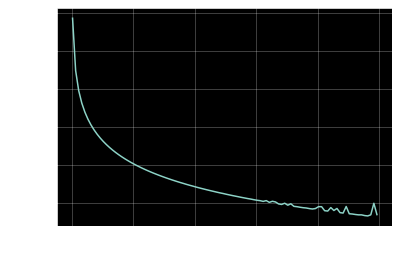

In [11]:
errtable = pd.DataFrame.from_dict(
    {
        "numpts": (min_n + step_n * np.asarray(range(len(err_linf)))),
        "abserror": err_linf,
    }
)
# print(errtable)
_ = plt.plot(errtable.numpts, errtable.abserror)
_ = plt.yscale("log")
_ = plt.xlabel("# of discretization points")
_ = plt.ylabel("Max error w.r.t. analytical sol.")
_ = plt.grid(alpha=0.3, which="both")

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [12]:
from functions import condition_number

condition_number(a)

5294.5583884256475

In [13]:
condition_number(a, inv_shf=True)

5294.558389301239

Implement a preconditioned Conjugate Gradient method to solve the original linear system of equations using an iterative method:

In [14]:
from functions import conjugate_gradient

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


**SOLUTION STEPS:**

- Apply the *Forward Euler* 1st-order-time-derivative approximation:  
  $$ \frac{\partial u}{\partial t} (x, t) \approx  \frac{u(x, t_{n+1} ) - u (x, t_n)}{h_t} $$

- Rewrite the PDE solution accordingly:  
  $$ u(x, t_{n+1} ) = u (x, t_n) + h_t \ u_{xx}(x, t_n) + h_t \ \alpha (t_n) \ f (x) $$

- Apply the space-approximation suggested before, as requested, i.e.:  
  $$ u_{xx}(t, x_i) = \frac{-u(t, x_{i-2})+16 u(t, x_{i-1})-30 u(t, x_{i})+16 u(t, x_{i+1})-u(t, x_{i+2})}{12h_{x}^2} $$
  A 2nd-order space-discretization scheme will be used for the (space-)discretization points where a 4th-order scheme is not applicable, as we did for the previous exercise, i.e.:
  $$u_{xx}(t,x_{i})=\frac{u(t,x_{i-1})-2u(t,x_{i})+u(t,x_{i+1})}{h_{x}^{2}} $$

- Substitute and rearrange the terms (for the 4th-order scheme):  
  $$ u(x_i, t_{n+1} ) =   h_t  \frac{-u(x_{i-2},t_n)+16u(x_{i-1}, t_n)+(-30 + 12 h_x^2/h_t) u(x_i, t_n)+16u(x_{i+1}, t_n) -u (x_{i+2}, t_n)}{12h_x^2} + h_t \alpha (t_n) f (x_i) $$  
  And analogously for the 2-nd order scheme.



In [15]:
from functions import fwd_euler_fd_solve

In [16]:
alpha = lambda x: np.cos(x)
f = lambda x: np.sin(x)
nt = int(1e5)
nx = int(1e2)
bc4pde = [np.array([0.0, np.pi]), np.sin, 0, 0] # [[a, b], u(0, x), u(t, a), u(t,b)]
ttot = 6 * np.pi

feuler_sol = fwd_euler_fd_solve(alpha, f, nt, nx, bc4pde, ttot)

In [17]:
from functions import idx_nearx

tspace = np.linspace(0.0, ttot, nt)
xspace = np.linspace(0.0, np.pi, nx)
sol_1 = feuler_sol[:, idx_nearx(x=np.pi/2, among=xspace)]
sol_2 = feuler_sol[:, idx_nearx(x=1, among=xspace)]
sol_3 = feuler_sol[:, idx_nearx(x=np.pi, among=xspace)]

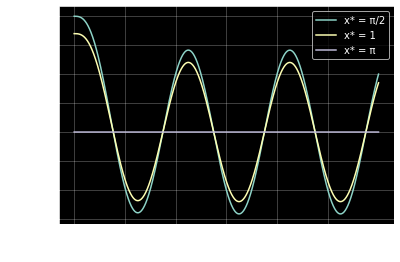

In [18]:
_ = plt.plot(tspace, sol_1, label="x* = π/2")
_ = plt.plot(tspace, sol_2, label="x* = 1")
_ = plt.plot(tspace, sol_3, label="x* = π")
_ = plt.xticks(*symfrac_ticks(0, 6, 1, np.pi, "π"))
_ = plt.xlabel("t")
_ = plt.ylabel("u(t, x*)")
_ = plt.grid(alpha=0.3, which="both")
_ = plt.legend(loc="best")

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [19]:
from functions import inverse_power_method_shf, eigv_ipm

In [20]:
eigvals, eigvects = eigv_ipm(a)

Compute the inverse of the matrix A exploiting the derived LU factorization

In [21]:
from functions import inv_lu

In [22]:
inva = inv_lu(a)

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [23]:
from functions import newton_method, backward_euler_method

In [24]:
f = lambda t, y: -t * y**2
fprime = lambda t, y: -2 * t * y
yexact = lambda t: 2 / (t**2 + 2.0)
f, fprime, yexact = map(np.vectorize, [f, fprime, yexact])

y0 = 1
nts = 500
tbounds = [0, 2]

tspace = np.linspace(*tbounds, nts)
euler_sol = backward_euler_method(y0, f, fprime, tbounds, nts)
exact_sol = yexact(tspace)

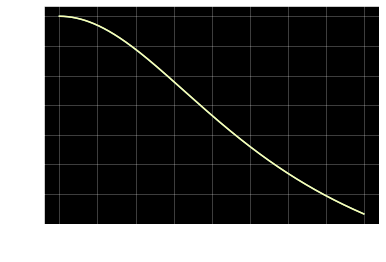

In [25]:
_ = plt.plot(tspace, euler_sol)
_ = plt.plot(tspace, exact_sol)
_ = plt.xlabel("t")
_ = plt.ylabel("y(t)")
_ = plt.grid(alpha=0.3, which="both")